# Matched UNIONS 800 deg^2 + ShapePipe shear catalogue

In [87]:
! pip install fast-histogram colorcet --upgrade

Requirement already up-to-date: fast-histogram in /Users/mkilbing/anaconda3/envs/photoz/lib/python3.7/site-packages (0.10)
Requirement already up-to-date: colorcet in /Users/mkilbing/anaconda3/envs/photoz/lib/python3.7/site-packages (3.0.0)


In [97]:
import numpy as np

import pandas as pd
import matplotlib.pylab as plt

from uncertainties import ufloat

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as units
import astropy.coordinates as coords

from collections import Counter

import colorcet as cc
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from fast_histogram import histogram2d

import functions as photoz

from sp_validation.plots import *

%matplotlib inline

In [2]:
base_name_ph = 'cfis_800d2_SP_v1.0'

In [3]:
fits.info(f'{base_name_ph}.fits')

Filename: cfis_800d2_SP_v1.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     58   18008780R x 25C   [D, D, D, D, D, D, D, D, D, K, D, D, D, K, D, D, D, D, D, D, D, D, D, D, D]   


In [4]:
hdu = fits.open(f'{base_name_ph}.fits', memmap=False)

#data = hdu[1].data

In [5]:
print(hdu._file.memmap)
print(hdu._file._mmap_available)
print(hdu._file._mmap)

False
True
None


In [6]:
data = hdu[1].data

In [7]:
# Print column names
print(data.dtype.names)

('ra', 'dec', 'g1', 'g2', 'w', 'mag', 'snr', 'g1_uncal', 'g2_uncal', 'CFIS_ID', 'RA', 'Dec', 'distance', 'CFIS_ID_mb', 'CFIS_U_MAG_AUTO', 'CFIS_U_MAGERR_AUTO', 'HSC_G_MAG_AUTO', 'HSC_G_MAGERR_AUTO', 'CFIS_R_MAG_AUTO', 'CFIS_R_MAGERR_AUTO', 'PS_i_stk_kron', 'PS_i_stk_kron_err', 'PS_z_stk_kron', 'PS_z_stk_kron_err', 'CFIS_R_StarGal')


## Plots

### Spatial distribution

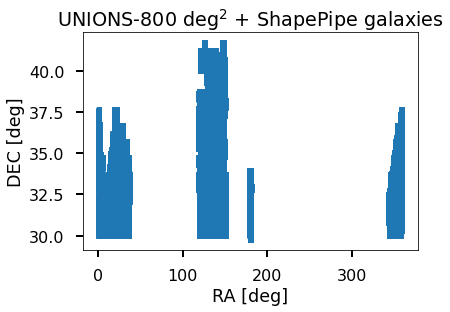

In [8]:
plt.plot(data['ra'], data['dec'], '.')
plt.title('UNIONS-800 deg$^2$ + ShapePipe galaxies')
plt.xlabel('RA [deg]')
_ = plt.ylabel('DEC [deg]')

In [30]:
ngal = len(data)
print(f'Number of galaxies = {ngal}')

Number of galaxies = 18008780


### Magnitude distribution (r-band)

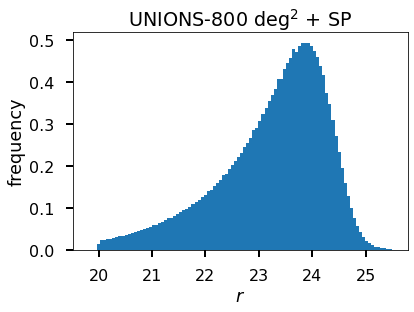

In [10]:
fig, (ax) = plt.subplots(1, 1)

range = (19.8, 25.5)

h = ax.hist(data['CFIS_R_MAG_AUTO'], bins=100, density=True, range=range)
plt.title('UNIONS-800 deg$^2$ + SP')
plt.xlabel('$r$')
plt.xticks(ticks=[20, 21, 22, 23, 24, 25])
_ = plt.ylabel('frequency')

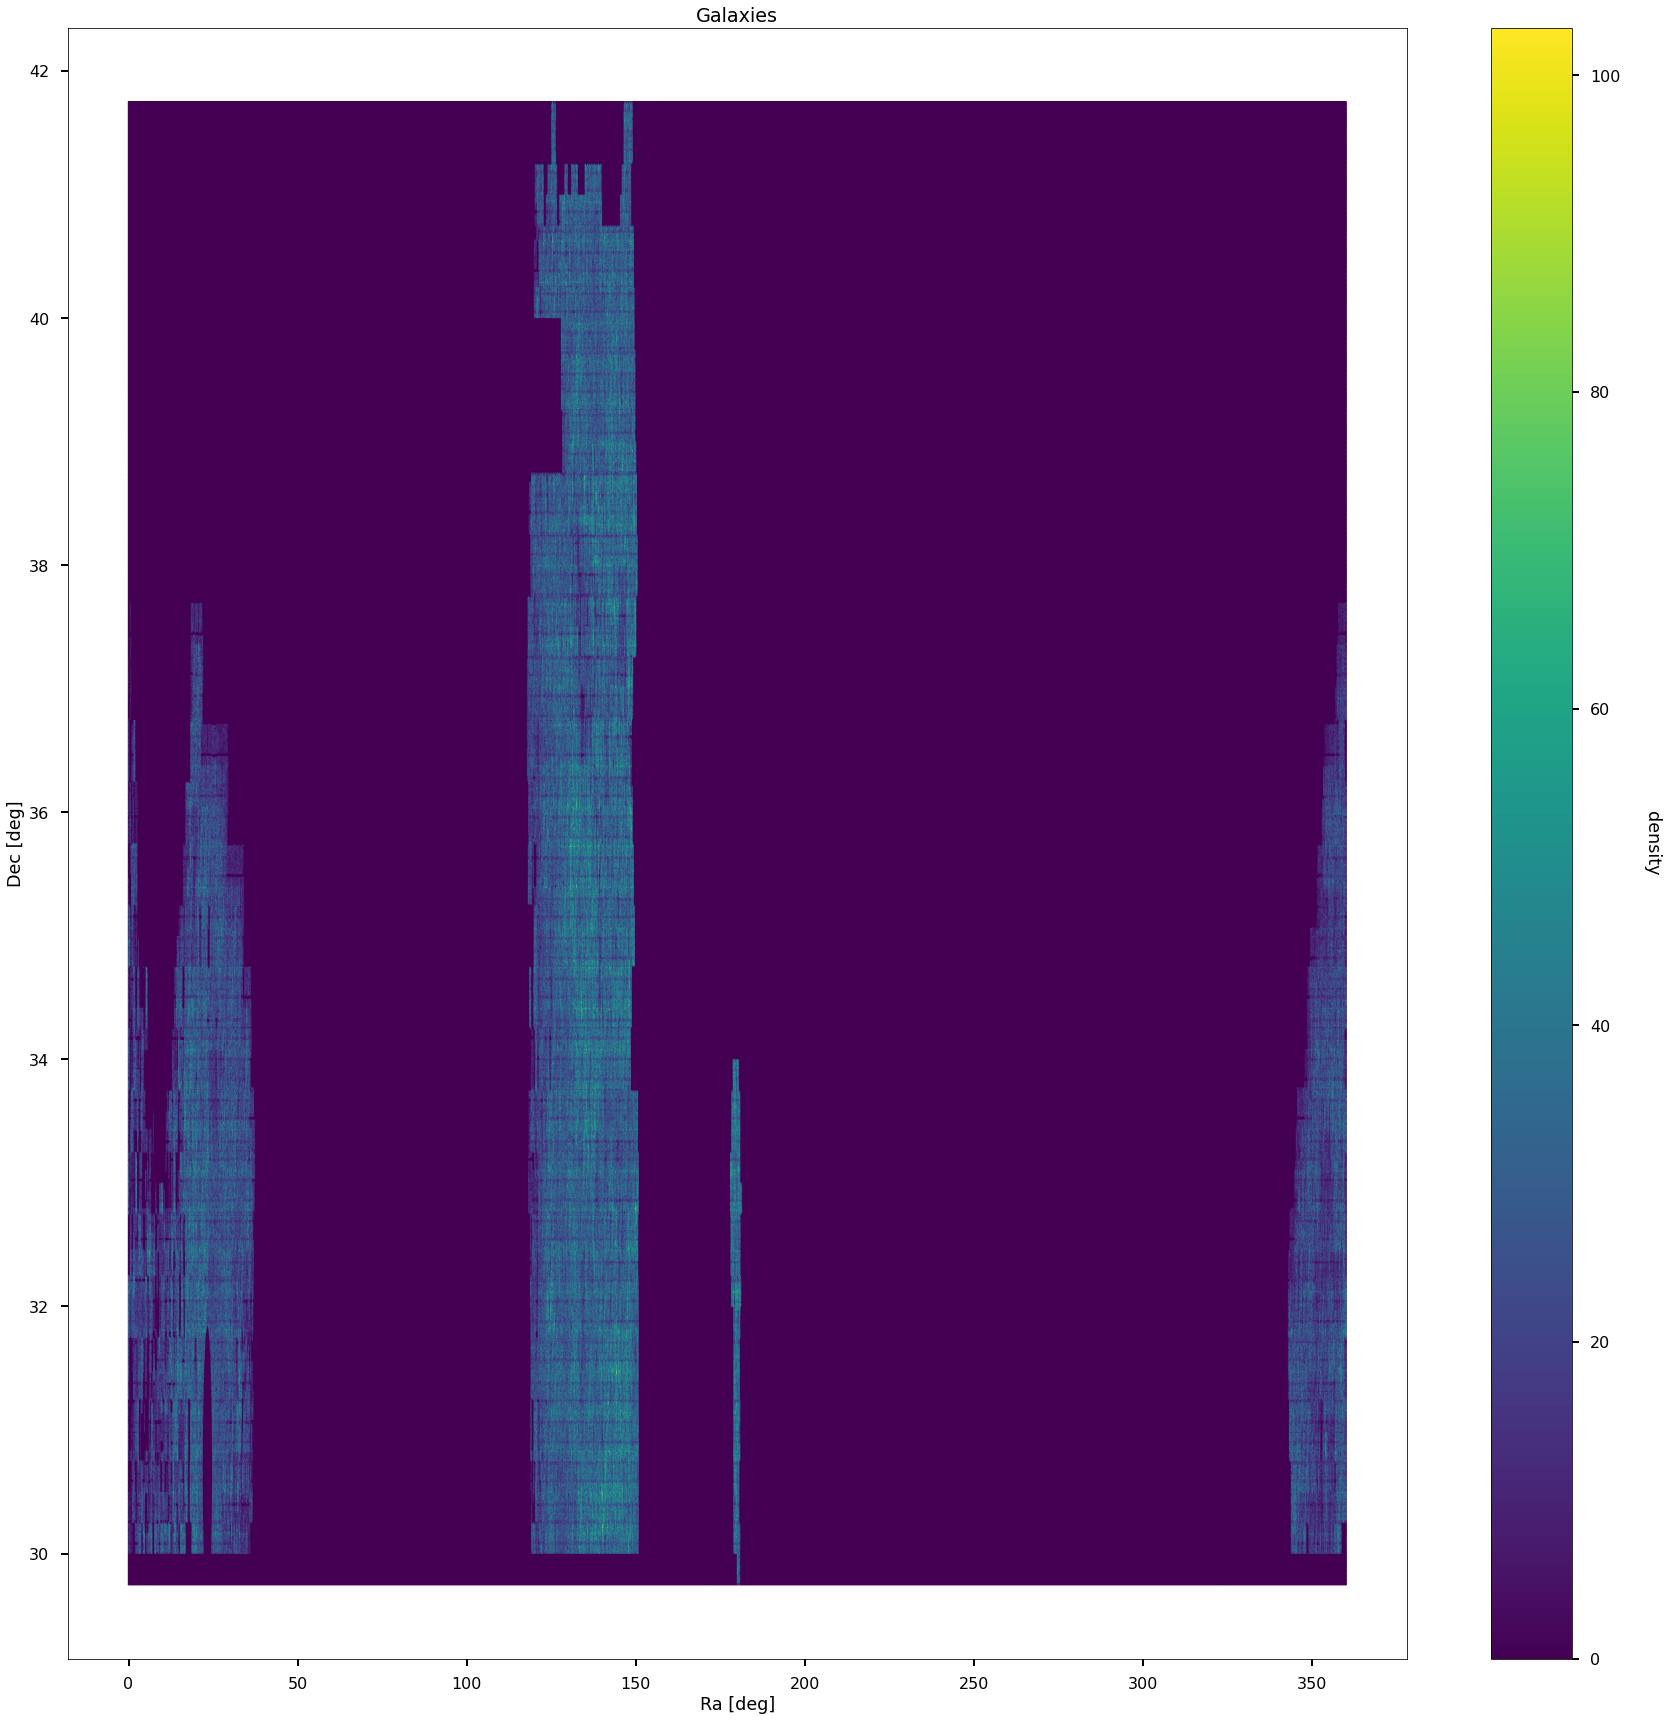

In [11]:
# Galaxies
n_grid = 2000
cbar_label = 'density'

title = 'Galaxies'
out_path = 'unions_800d2+SP'
plot_spatial_density(
    data['RA'],
    data['Dec'],
    title,
    'Ra [deg]',
    'Dec [deg]',
    cbar_label,
    out_path,
    n_grid=n_grid,
    verbose=True
)

In [12]:
## Some consistency checks

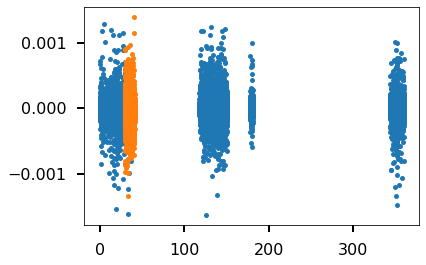

In [13]:
plt.plot(data['RA'], data['RA']-data['ra'], '.')
plt.plot(data['Dec'], data['Dec']-data['dec'], '.')

#### Check distances

In [14]:
# ShapePipe coordinates
ra_sp = coords.Angle(data['ra'], unit='deg')
dec_sp = coords.Angle(data['dec'], unit='deg')

# 800 deg^2 coordinates
ra_ext = coords.Angle(data['RA'], unit='deg')
dec_ext = coords.Angle(data['Dec'], unit='deg')

In [15]:
# Haversine distance, better than standard formula for small distances,
# avoiding cosine calls
# https://en.wikipedia.org/wiki/Great-circle_distance
delta_ra_half = (ra_sp - ra_ext) / 2
delta_dec_half = (dec_sp - dec_ext) / 2
sum_dec_half = (dec_sp + dec_ext) / 2
tmp = np.sin(delta_dec_half)**2 + ( 1 - np.sin(delta_dec_half)**2  - np.sin(sum_dec_half)**2 ) * np.sin(delta_ra_half)**2
dist_hav = 2 * np.arcsin( np.sqrt(tmp) ).to('arcsec').value

In [16]:
d = (
    np.sin(dec_sp) * np.sin(dec_ext)
    + np.cos(dec_sp) * np.cos(dec_sp) * np.cos(ra_sp - ra_ext)
)

In [17]:
w = np.where(np.abs(d) > 1)

In [18]:
dist_gc = np.arccos(d).to('arcsec')
dist_gc[w] = 0

In [19]:
dist_gc

<Quantity [ 0.        ,  0.        ,  0.        , ..., 28.42679079,
            0.        , 97.37020217] arcsec>

In [20]:
dist_hav

array([0.16003225, 0.00806815, 0.04403121, ..., 0.00763281, 0.02234392,
       0.06343718])

In [21]:
data['distance']

array([0.01894415, 0.02367865, 0.02353498, ..., 0.01386416, 0.01563864,
       0.06739219])

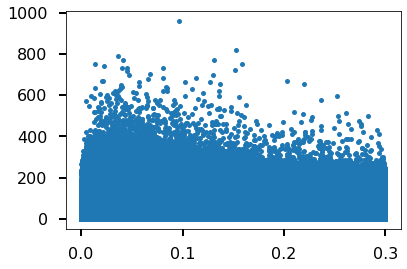

In [22]:
plt.plot(data['distance'], dist_gc, '.')

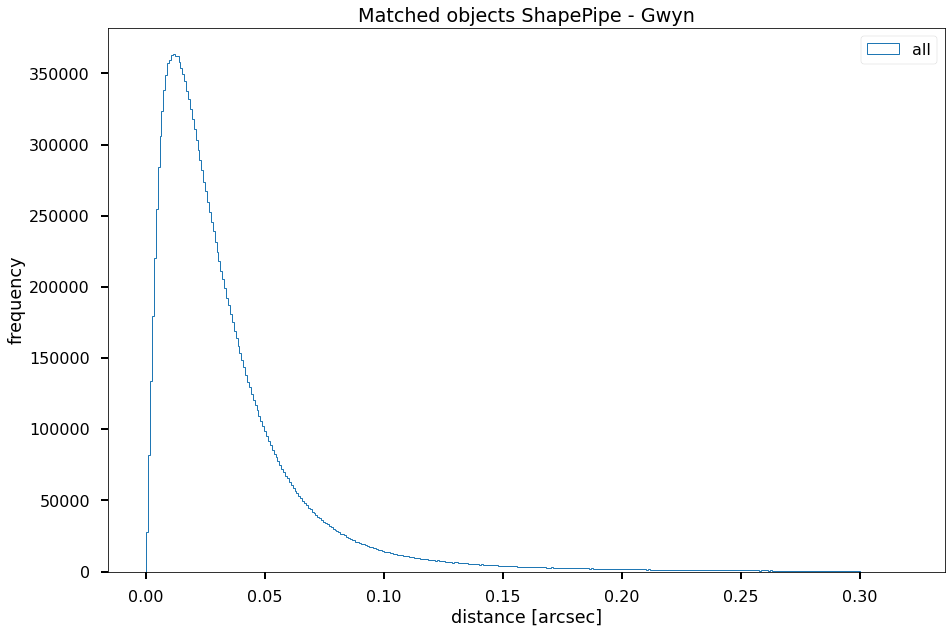

In [23]:
# Plot histogram of distances
xs = [data['distance']]
labels = ['all']
title = 'Matched objects ShapePipe - Gwyn'
x_label = 'distance [arcsec]'
y_label = 'frequency'
x_range = (0, 0.32)
n_bin = 400
out_path = 'hist_matched_dist.pdf'

plot_histograms(
    xs,
    labels,
    title,
    x_label,
    y_label,
    x_range,
    n_bin,
    out_path,
    weights=None,
    colors=None,
    linestyles=None,
    vline_x=None,
    vline_lab=None,
    density=False,
)

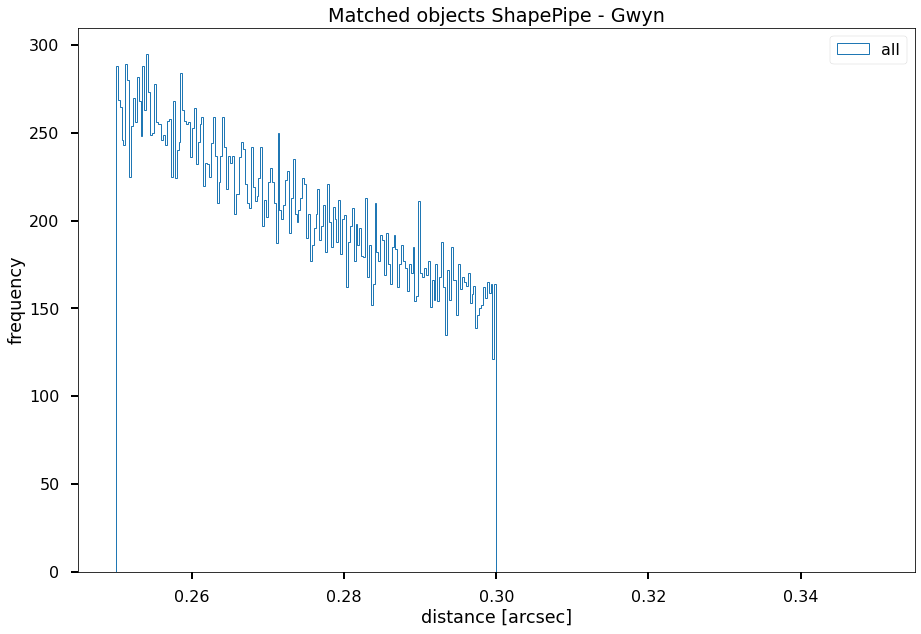

In [24]:
# Plot histogram of distances
xs = [data['distance']]
labels = ['all']
title = 'Matched objects ShapePipe - Gwyn'
x_label = 'distance [arcsec]'
y_label = 'frequency'
x_range = (0.25, 0.35)
n_bin = 400
out_path = 'hist_matched_dist_large.pdf'

plot_histograms(
    xs,
    labels,
    title,
    x_label,
    y_label,
    x_range,
    n_bin,
    out_path,
    weights=None,
    colors=None,
    linestyles=None,
    vline_x=None,
    vline_lab=None,
    density=False,
)

In [25]:
print(data['mag'][:10])
print(data['CFIS_R_MAG_AUTO'][:10])

[22.36566925 23.46311951 23.59436989 22.51903152 23.63842583 24.01603889
 23.14931297 21.01479721 23.69986343 23.48737717]
[22.385 23.378 23.741 22.508 23.619 24.008 23.11  20.973 23.722 23.41 ]


### Stats of valid/invalid magnitudes

In [70]:
wn99 = (data['CFIS_R_MAG_AUTO'] != -99)
wn999 = (data['CFIS_R_MAG_AUTO'] != -999)

In [72]:
nn99 = len(np.where(wn99)[0])
print(f'fraction of galaxies with (R != -99 / detected) = {nn99}/{ngal} = {nn99/ngal*100:.1f}%')

nn999 = len(np.where(wn999)[0])
print(f'fraction of galaxies with (R != -999 / covered) = {nn999}/{ngal} = {nn999/ngal*100:.1f}%')

fraction of galaxies with (R != -99 / detected) = 18008780/18008780 = 100.0%
fraction of galaxies with (R != -999 / covered) = 17999244/18008780 = 99.9%


In [98]:
print(data.dtype.names)

('ra', 'dec', 'g1', 'g2', 'w', 'mag', 'snr', 'g1_uncal', 'g2_uncal', 'CFIS_ID', 'RA', 'Dec', 'distance', 'CFIS_ID_mb', 'CFIS_U_MAG_AUTO', 'CFIS_U_MAGERR_AUTO', 'HSC_G_MAG_AUTO', 'HSC_G_MAGERR_AUTO', 'CFIS_R_MAG_AUTO', 'CFIS_R_MAGERR_AUTO', 'PS_i_stk_kron', 'PS_i_stk_kron_err', 'PS_z_stk_kron', 'PS_z_stk_kron_err', 'CFIS_R_StarGal')


In [103]:
bands = ['U', 'G', 'R', 'i', 'z']
cols = ['CFIS_U_MAG_AUTO', 'HSC_G_MAG_AUTO', 'CFIS_R_MAG_AUTO', 'PS_i_stk_kron', 'PS_z_stk_kron']

wn99 = {}
wn999 = {}

for b, c in zip(bands, cols):
    wn99[b] = (data[c] != -99)
    wn999[b] = (data[c] != -999)

for b in bands:
    nn99 = len(np.where(wn99[b])[0])
    print(f'fraction of galaxies with ({b} != -99 / detected) = {nn99}/{ngal} = {nn99/ngal*100:.1f}%')

print()
for b in bands:
    nn999 = len(np.where(wn999[b])[0])
    print(f'fraction of galaxies with ({b} != -999 / covered) = {nn999}/{ngal} = {nn999/ngal*100:.1f}%')

fraction of galaxies with (U != -99 / detected) = 6144908/18008780 = 34.1%
fraction of galaxies with (G != -99 / detected) = 12707011/18008780 = 70.6%
fraction of galaxies with (R != -99 / detected) = 18008780/18008780 = 100.0%
fraction of galaxies with (i != -99 / detected) = 11258027/18008780 = 62.5%
fraction of galaxies with (z != -99 / detected) = 7499428/18008780 = 41.6%

fraction of galaxies with (U != -999 / covered) = 17861384/18008780 = 99.2%
fraction of galaxies with (G != -999 / covered) = 14894223/18008780 = 82.7%
fraction of galaxies with (R != -999 / covered) = 17999244/18008780 = 99.9%
fraction of galaxies with (i != -999 / covered) = 17856218/18008780 = 99.2%
fraction of galaxies with (z != -999 / covered) = 17759570/18008780 = 98.6%


In [113]:
n99n999 = wn99['U'] & wn99['R'] & wn99['G'] & wn99['i'] & wn99['z'] \
    & wn999['U'] & wn999['R'] & wn999['G'] & wn999['i'] & wn999['z']
n999 = (wn999['U'] & wn999['R'] & wn999['G'] & wn999['i'] & wn999['z'])

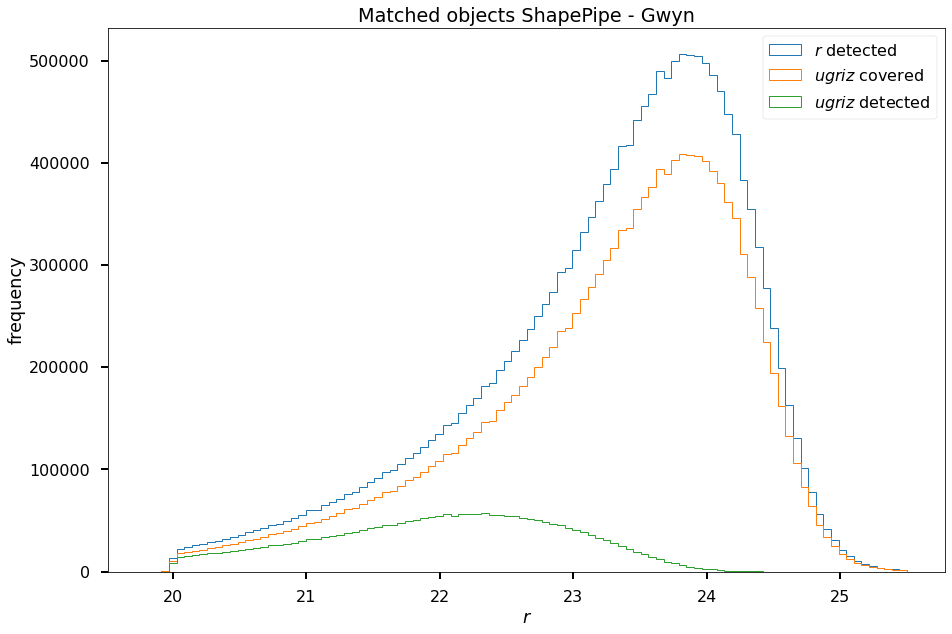

In [120]:
xs = [data['CFIS_R_MAG_AUTO'], data['CFIS_R_MAG_AUTO'][n999], data['CFIS_R_MAG_AUTO'][n99n999]]
labels = [r'$r$ detected' ,r'$ugriz$ covered', r'$ugriz$ detected']
title = 'Matched objects ShapePipe - Gwyn'
x_label = '$r$'
y_label = 'frequency'
x_range = (19.8, 25.5)
n_bin = 100
out_path = 'hist_r.pdf'

plot_histograms(
    xs,
    labels,
    title,
    x_label,
    y_label,
    x_range,
    n_bin,
    out_path,
    weights=None,
    colors=None,
    linestyles=None,
    density=False,
)

In [73]:
mask_match = wn99 & wn999

### Magnitude differences

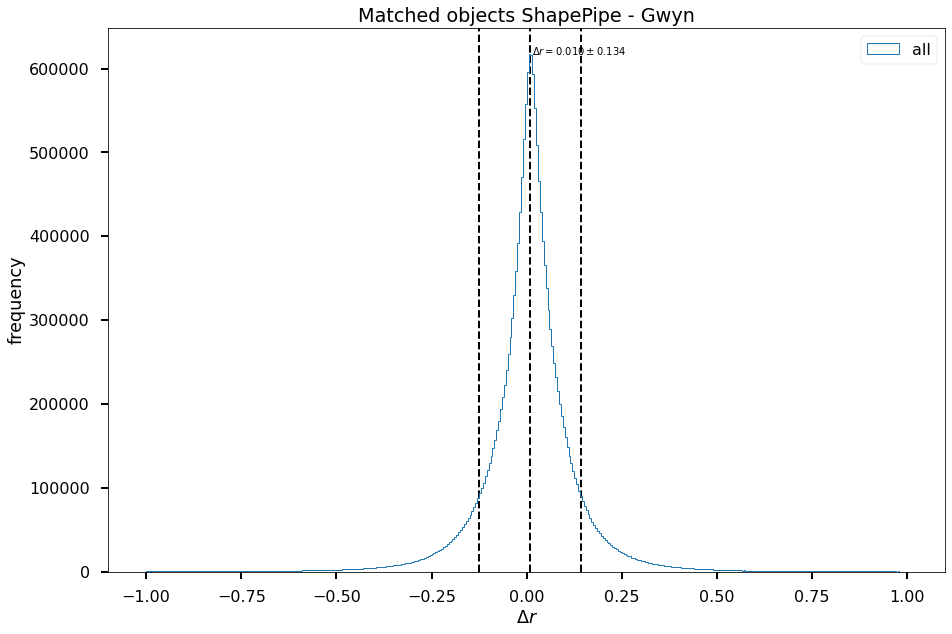

In [78]:
dr = data['mag'][mask_match] - data['CFIS_R_MAG_AUTO'][mask_match]
dr_rel = dr /data['CFIS_R_MAGERR_AUTO'][mask_match]

xs = [dr]
labels = ['all']
title = 'Matched objects ShapePipe - Gwyn'
x_label = '$\Delta r$'
y_label = 'frequency'
x_range = (-1, 1)
n_bin = 400
out_path = 'hist_matched_dr.pdf'

mu = np.mean(dr)
med = np.median(dr)
rms = np.std(dr)

m_dm = ufloat(med, rms)

plot_histograms(
    xs,
    labels,
    title,
    x_label,
    y_label,
    x_range,
    n_bin,
    out_path,
    weights=None,
    colors=None,
    linestyles=None,
    vline_x=[med, med-rms, med+rms],
    vline_lab=[f'$\Delta r={m_dm:.3ugL}$', '', ''],
    density=False,
)

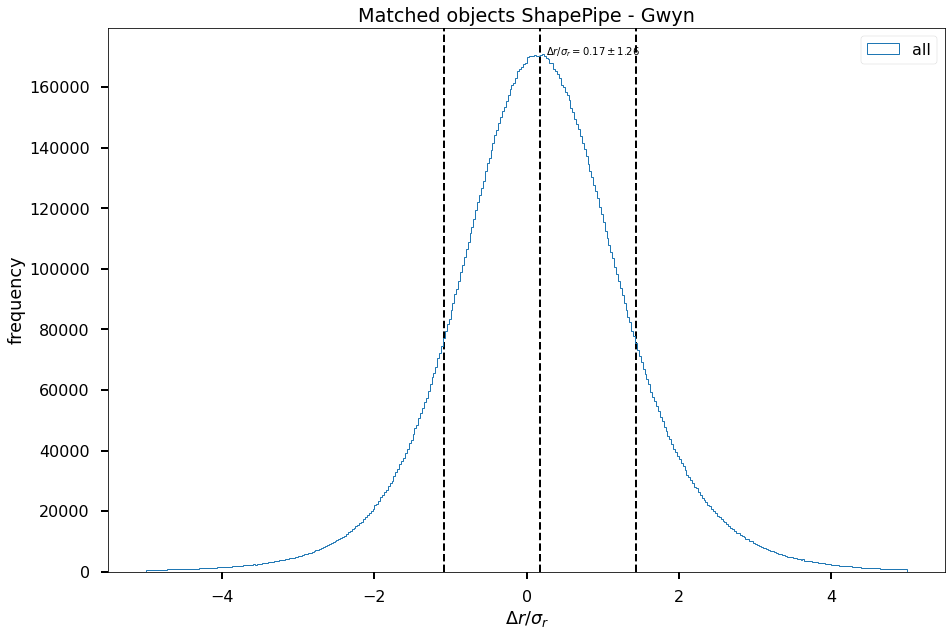

In [79]:
xs = [dr_rel]
labels = ['all']
title = 'Matched objects ShapePipe - Gwyn'
x_label = '$\Delta r / \sigma_r$'
y_label = 'frequency'
x_range = (-5, 5)
n_bin = 400
out_path = 'hist_matched_dr_rel.pdf'

mu = np.mean(dr_rel)
med = np.median(dr_rel)
rms = np.std(dr_rel)

m_dm = ufloat(med, rms)

plot_histograms(
    xs,
    labels,
    title,
    x_label,
    y_label,
    x_range,
    n_bin,
    out_path,
    weights=None,
    colors=None,
    linestyles=None,
    vline_x=[med, med-rms, med+rms],
    vline_lab=[f'$\Delta r/\sigma_r={m_dm:.3ugL}$', '', ''],
    density=False,
)

### Scatter plot of magnitude vs. magnitude difference

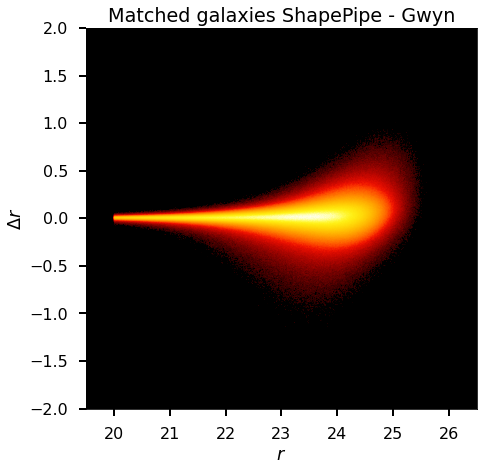

In [96]:
cc.cm["fire"].set_under('k')
cc.cm["fire"].set_bad('k')
cc.cm["fire"].set_over('k')

Y = data['mag'][mask_match]
X = dr

#bounds = [[X.min(), X.max()], [Y.min(), Y.max()]]
bounds = [[-2, 2], [19.5, 26.5]]
h = histogram2d(X, Y, range=bounds, bins=1000)

fig = plt.figure(figsize=(7, 7), tight_layout=False)

plt.title('Matched galaxies ShapePipe - Gwyn')

plt.imshow(h, norm=colors.LogNorm(vmin=1, vmax=h.max()), cmap=cmap, origin='lower',
           extent=[bounds[1][0], bounds[1][1], bounds[0][0], bounds[0][1]], aspect='auto')
plt.xlabel('$r$')
ylab = plt.ylabel('$\Delta r$')

plt.savefig('r_dr.pdf')